# How to use Conformal Prediction

In [2]:
import random

random.seed(123)

## An introducing Example

### Dry Bean Data

Classify beans of 7 different varieties (classes), each with 16 characteristics (features).

In [3]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
  
# fetch dataset 
dry_bean_dataset = fetch_ucirepo(id=602) 
  
X = dry_bean_dataset.data.features 
y = dry_bean_dataset.data.targets.values.flatten()

# Encode the classes to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
  
# variable information 
display(dry_bean_dataset.variables)

,name,role,type,demographic,description,units,missing_values
0,Area,Feature,Integer,None,The area of a bean zone and the number of pixe...,pixels,no
1,Perimeter,Feature,Continuous,None,Bean circumference is defined as the length of...,None,no
2,MajorAxisLength,Feature,Continuous,None,The distance between the ends of the longest l...,None,no
3,MinorAxisLength,Feature,Continuous,None,The longest line that can be drawn from the be...,None,no
4,AspectRatio,Feature,Continuous,None,Defines the relationship between MajorAxisLeng...,None,no
5,Eccentricity,Feature,Continuous,None,Eccentricity of the ellipse having the same mo...,None,no
6,ConvexArea,Feature,Integer,None,Number of pixels in the smallest convex polygo...,None,no
7,EquivDiameter,Feature,Continuous,None,Equivalent diameter: The diameter of a circle ...,None,no
8,Extent,Feature,Continuous,None,The ratio of the pixels in the bounding box to...,None,no
9,Solidity,Feature,Continuous,None,Also known as convexity. The ratio of the pixe...,None,no


### Data Splitting

In [4]:
from sklearn.model_selection import train_test_split

# Training and remaining sets
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=10000, random_state=42)
print(X_train.shape)

# Test and remaining sets
X_temp2, X_test, y_temp2, y_test = train_test_split(X_temp, y_temp, test_size=1000, random_state=42)
print(X_test.shape)

# Calibration and conformal prediction sets
X_new, X_calib, y_new, y_calib = train_test_split(X_temp2, y_temp2, test_size=1000, random_state=42)
print(X_calib.shape)
print(X_new.shape)

# X_train, y_train: Training data
# X_test, y_test: Test data
# X_calib, y_calib: Calibration data
# X_new, y_new: Conformal prediction data

(10000, 16)
(1000, 16)
(1000, 16)
(1611, 16)


### Modeling

#### Training

In [5]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB().fit(X_train, y_train)

#### Testing

In [6]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.76


$\rightarrow$ Poor predictive accuracy is highlighting uncertainty in prediction! Need to quantify it.

Next: Construct prediction sets for each observation and calculate (average/marginal) coverage

In [14]:
import numpy as np

# Heuristic class "probabilities"
class_probs_new = model.predict_proba(X_new)

prediction_sets = []
for prob in class_probs_new:
    sorted_classes = np.argsort(prob)[::-1]  # Sort classes by heuristic class "probabilities" in descending order
    cumulative_prob = 0
    prediction_set = []
    for cl in sorted_classes:
        if cumulative_prob < 0.95:  # 95% for alpha=0.05
            prediction_set.append(cl)
            cumulative_prob += prob[cl]
        else:
            break
    prediction_sets.append(prediction_set)

# Coverage
# How frequently the true class is in the prediction set?
matches = [true_label in pred_set for true_label, pred_set in zip(y_new, prediction_sets)]
coverage = np.mean(matches)

# Average prediction set size
avg_set_size = np.mean([len(pred_set) for pred_set in prediction_sets])

# Print the results
print(f'Nominal Coverage: 0.95')
print(f'Empirical Coverage: {coverage:.2f}')
print(f'Avg. set size: {avg_set_size:.1f}')

Nominal Coverage: 0.95
Empirical Coverage: 0.89
Avg. set size: 1.4


Example: prediction sets per sample

In [8]:
for i,s in enumerate(prediction_sets[:10]):
    print('Sample',i,s)

Sample 0 [2, 0]
Sample 1 [3]
Sample 2 [2, 0]
Sample 3 [6]
Sample 4 [4, 6]
Sample 5 [5]
Sample 6 [3]
Sample 7 [3, 5]
Sample 8 [6, 5]
Sample 9 [4, 6]


## Score Method

### Non-Conformity Score: $1 - \hat f(X_{i})_{Y_{i}}$

In [11]:
# Heuristic class "probabilities"
predictions = model.predict_proba(X_calib)

# Extract the predicted probabilities for each sample's true class
prob_true_class = predictions[np.arange(len(X_calib)), y_calib]

# Compute the uncertainty/non-conformity score (larger values indicate higher uncertainty)
scores = 1 - prob_true_class

### Estimating the Threshold of $s_i$

$\hat q = \frac{(n+1)\cdot(1-\alpha)}{n}$

In [13]:
# Sign. level / FP error rate
alpha = 0.05

# Calculate the empirical quantile level
q_level = np.ceil((len(scores) + 1) * (1 - alpha)) / len(scores)

# Compute the quantile threshold from the uncertainty scores
qhat = np.quantile(scores, q_level, interpolation='higher')

print(f'Quantile threshold: {qhat:.4f}')

Quantile threshold: 0.9987


### Plot

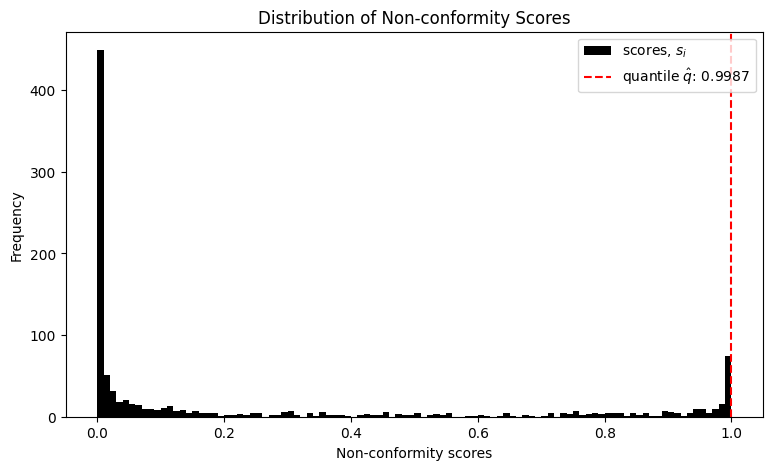

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,5))

# Plotting the histogram of scores
plt.hist(scores, bins=100, color='black', alpha=1, label='scores, ${s_i}$')
plt.axvline(x=qhat, color='red', linestyle='--', label=f'quantile $\hat{{q}}$: {qhat:.4f}')
plt.xlabel('Non-conformity scores')
plt.ylabel('Frequency')
plt.title('Distribution of Non-conformity Scores')
plt.legend(loc='upper right')
plt.show()

Threshold provides a limit for the non-conformity scores s, up to which a class should be included in our prediction set $C$.

Let's see if this works by checking its coverage

### Coverage Probability Test

Construct prediction set: $C(X_{i}) = \{y_{i}: s(X_{i},y_{i}) \leq \hat q \}, i = 1....n$

In [41]:
prediction_sets = []

for i in range(len(X_new)):
    prob_sample = model.predict_proba(X_new[i:i+1])[0]    # predict class prob for sample i
    uncertainty_scores = 1 - prob_sample                  # compute uncertainty scores  
    prediction_set = [cl for cl, score in enumerate(uncertainty_scores) if score <= qhat]     # select classes with scores <= qhat
    prediction_sets.append(prediction_set)

# Coverage probability
matches = [true_label in pred_set for true_label, pred_set in zip(y_new, prediction_sets)]
coverage = np.mean(matches)

# Average set size
avg_set_size = np.mean([len(pred_set) for pred_set in prediction_sets])

# Print the results
print(f'Nominal Coverage: 0.95')
print(f'Empirical Coverage: {coverage:.2f}')
print(f'Avg. set size: {avg_set_size:.1f}')

Nominal Coverage: 0.95
Empirical Coverage: 0.95
Avg. set size: 1.8


It can be shown (cf. https://arxiv.org/abs/2107.07511) that 

$1-\alpha \leq P(Y_{test} \in C(X_{test})) \leq 1-\alpha + \frac{1}{n+1}$

e.g. for $n = 1000$, as in the example, the upper bound is limited to round about $95.1\%$ 

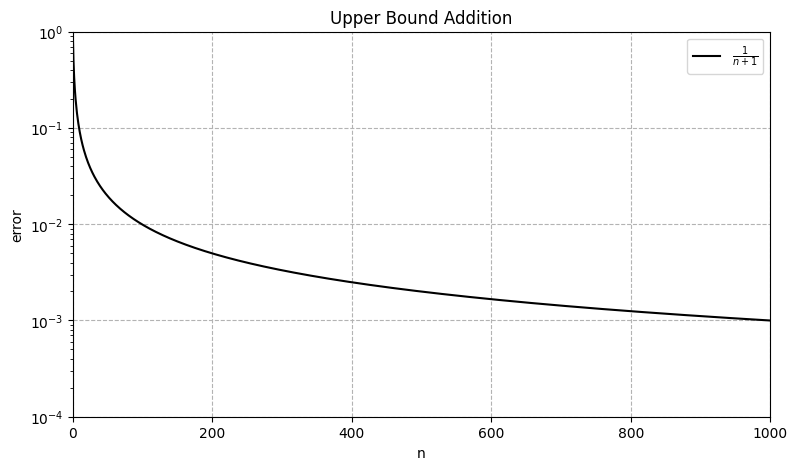

In [43]:
def plot_function(x_limits, y_limits):
    # x values
    x = np.linspace(x_limits[0], x_limits[1], 1000)
    y = 1 / (x + 1)

    plt.figure(figsize=(9, 5))
    
    # Plot
    plt.plot(x, y, label=r'$\frac{1}{n+1}$', color = 'black')
    
    # Limits
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.yscale('log')
    
    # Labels & co.
    plt.title(r'Upper Bound Addition')
    plt.xlabel('n')
    plt.ylabel('error')
    plt.legend()
    
    plt.grid(True, which="major", ls="--", c='0.7')
    plt.show()

x_limits = [0, 1000]  # Begrenzungen für x
y_limits = [0.0001, 1]  # Begrenzungen für y (log-skaliert)
plot_function(x_limits, y_limits)

Note: the above algorithm gives prediction sets that are guaranteed to satisfy these inequalities, no matter how bad our model is or what the (unknown) distribution of the data is!

Only assumption: If the joint distribution of the data we try to predict is very different from the data we used for calibration, we won't get valid prediction sets C. This is slightly weaker than the i.i.d. assumption.

## The Generality of Conformal Prediction

### Conditional Class Probabilities

Score method yields smallest prediction sets, its coverage probability can vary from class to class and is only correct on average 

In [44]:
n_classes = 7
class_counts = [0] * n_classes
class_matches = [0] * n_classes

for i in range(len(X_new)):
    prob_sample = model.predict_proba(X_new[i:i+1])[0]
    uncertainty_scores = 1 - prob_sample
    prediction_set = [cls for cls, score in enumerate(uncertainty_scores) if score <= qhat]

    # Updating counters
    true_label = y_new[i]
    class_counts[true_label] += 1            # construct class distribution
    if true_label in prediction_set:
        class_matches[true_label] += 1         # class conditional matches

# Coverage probabilities for each class
class_coverages = [match / count if count > 0 else 0 for match, count in zip(class_matches, class_counts)]

# Results
for i, coverage in enumerate(class_coverages):
    print(f'Coverage for class {i}: {coverage:.2f}')

print(f'Overall Coverage: {sum(class_matches) / sum(class_counts):.2f}')

Coverage for class 0: 0.93
Coverage for class 1: 1.00
Coverage for class 2: 0.97
Coverage for class 3: 0.96
Coverage for class 4: 0.94
Coverage for class 5: 0.95
Coverage for class 6: 0.95
Overall Coverage: 0.95


(Class) Conditional coverage is desired -> Adaptive Prediction Sets algorithm can achieve this

## Conformal Regression

### Wine Quality Data

In [45]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = np.array(wine_quality.data.targets, dtype=float)
  
# variable information 
display(wine_quality.variables)

,name,role,type,demographic,description,units,missing_values
0,fixed_acidity,Feature,Continuous,None,None,None,no
1,volatile_acidity,Feature,Continuous,None,None,None,no
2,citric_acid,Feature,Continuous,None,None,None,no
3,residual_sugar,Feature,Continuous,None,None,None,no
4,chlorides,Feature,Continuous,None,None,None,no
5,free_sulfur_dioxide,Feature,Continuous,None,None,None,no
6,total_sulfur_dioxide,Feature,Continuous,None,None,None,no
7,density,Feature,Continuous,None,None,None,no
8,pH,Feature,Continuous,None,None,None,no
9,sulphates,Feature,Continuous,None,None,None,no


### Splitting Data

In [46]:
# Training and remaining sets
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=2500, random_state=42)

# Test and remaining sets
X_temp2, X_test, y_temp2, y_test = train_test_split(X_temp, y_temp, test_size=1000, random_state=42)

# Calibration and conformal prediction sets
X_new, X_calib, y_new, y_calib = train_test_split(X_temp2, y_temp2, test_size=1000, random_state=42)

# Now you have:
# X_train, y_train: Training data
# X_test, y_test: Test data
# X_calib, y_calib: Calibration data
# X_new, y_new: Conformal prediction data

### Modeling

#### Training

In [47]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)

#### Testing

In [50]:
from sklearn.metrics import mean_absolute_error

# Vorhersage für den Testdatensatz
y_pred = model.predict(X_test)

# Berechnung des MAE
mae = mean_absolute_error(y_test, y_pred)

print(f'R^2: {model.score(X_test, y_test):.2f}')
print(f'MAE: {mae:.2f}')

R^2: 0.28
MAE: 0.59


### Bootstrapping

#### Procedure

In [56]:
from sklearn.utils import resample
from tqdm import tqdm

n_iterations = 2*10**3

# Error Rate
alpha = 0.05

# Bootstrapping
all_preds = []

for _ in tqdm(range(n_iterations)):
    # Resampling
    X_resampled, y_resampled = resample(X_train, y_train)

    # Retraining
    model = LinearRegression().fit(X_resampled, y_resampled)

    # Prediction
    y_pred = model.predict(X_new)

    all_preds.append(y_pred)

all_preds = np.array(all_preds) 

# Prediction Interval
lower = np.percentile(all_preds, 100 * alpha / 2, axis=0)
upper = np.percentile(all_preds, 100 * (1 - alpha / 2), axis=0)

100%|██████████| 2000/2000 [00:49<00:00, 40.11it/s]


#### Coverage Probability

In [57]:
# Number of matches
matches = [(y_true >= lower[i]) & (y_true <= upper[i]) for i, y_true in enumerate(y_new)]

# Coverage Probability
coverage = np.mean(matches)

# Average interval width
avg_interval_width = np.mean(upper - lower)

# Result
print(f'Coverage: {coverage:.2f}')
print(f'Avg. interval width: {avg_interval_width:.2f}')

Coverage: 0.10
Avg. interval width: 0.21


#### Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


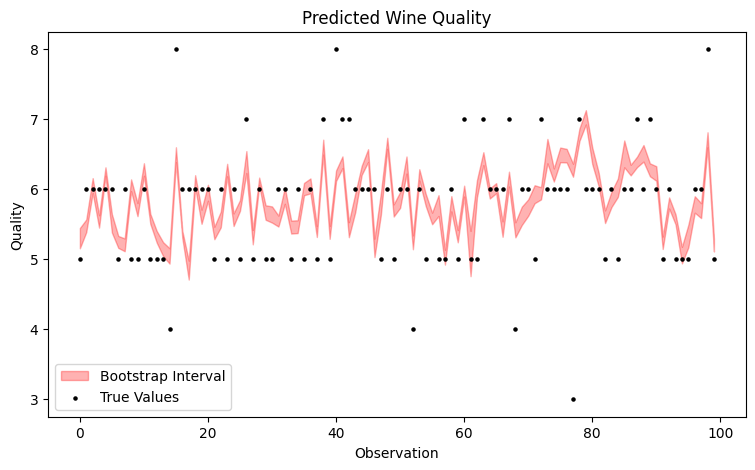

In [58]:
def plot_bootstrap_intervals(lower, upper, y_new, start=0, end=None):

    subset_range = slice(start, end)

    # Ensuring data is 1D
    lower = np.array(lower).flatten()
    upper = np.array(upper).flatten()
    y_new = np.array(y_new).flatten()
    
    fig, ax = plt.subplots(figsize=(9,5))
    
    plt.xlabel('Observation')
    plt.ylabel('Quality')
    plt.title('Predicted Wine Quality')
    plt.legend(loc='upper right')

    # Intervals
    plt.fill_between(np.arange(start, end if end is not None else len(lower)),
                     lower[subset_range], 
                     upper[subset_range], 
                     color='red', 
                     alpha=0.3, 
                     label='Bootstrap Interval')

    # True values
    plt.scatter(np.arange(start, end if end is not None else len(y_new)), 
                y_new[subset_range], 
                color='black', 
                s=5, 
                label='True Values')

    plt.legend()
    plt.show()

plot_bootstrap_intervals(lower, upper, y_new, start=0, end=100)  # This will display the first 100 data points

### Non-conformity Scores

In [59]:
# Predicitions
predictions = model.predict(X_calib)

# Non-conformity score / MAE
scores = np.abs(y_calib - predictions)

### Estimating Treshold

In [60]:
# Error rate
alpha = 0.05

# Quantile
q_level = np.ceil((len(scores) + 1) * (1 - alpha)) / len(scores)

# Treshold
qhat = np.quantile(scores, q_level, interpolation='higher')

### Plot

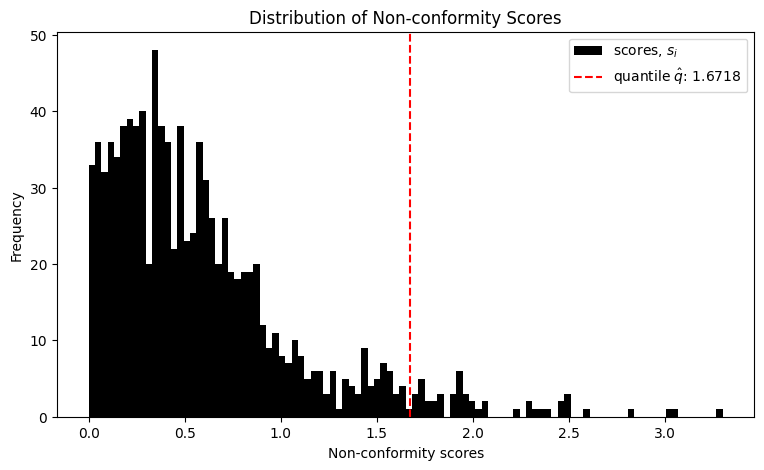

In [61]:
# Size
fig, ax = plt.subplots(figsize=(9,5))

# Plot
plt.hist(scores, bins=100, color='black', alpha=1, label='scores, ${s_i}$')
plt.axvline(x=qhat, color='red', linestyle='--', label=f'quantile $\hat{{q}}$: {qhat:.4f}')
plt.xlabel('Non-conformity scores')
plt.ylabel('Frequency')
plt.title('Distribution of Non-conformity Scores')
plt.legend(loc='upper right')
plt.show()

### Coverage Probability 

In [62]:
# Prediction intervals
lower_bounds = []
upper_bounds = []

for i in range(len(X_new)):
    pred = model.predict(X_new[i:i+1])[0]
    lower = pred - qhat  # or another formula based on residuals and qhat
    upper = pred + qhat  # similarly adjust as necessary
    lower_bounds.append(lower)
    upper_bounds.append(upper)

# Coverage probability
matches = [(true_val >= lower) and (true_val <= upper) 
           for true_val, lower, upper in zip(y_new, lower_bounds, upper_bounds)]

coverage = np.mean(matches)

# Average interval width
avg_interval_width = np.mean([upper - lower for lower, upper in zip(lower_bounds, upper_bounds)])

# Print the results
print(f'Coverage: {coverage:.2f}')
print(f'Avg. interval width: {avg_interval_width:.1f}')

Coverage: 0.97
Avg. interval width: 3.3


### Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


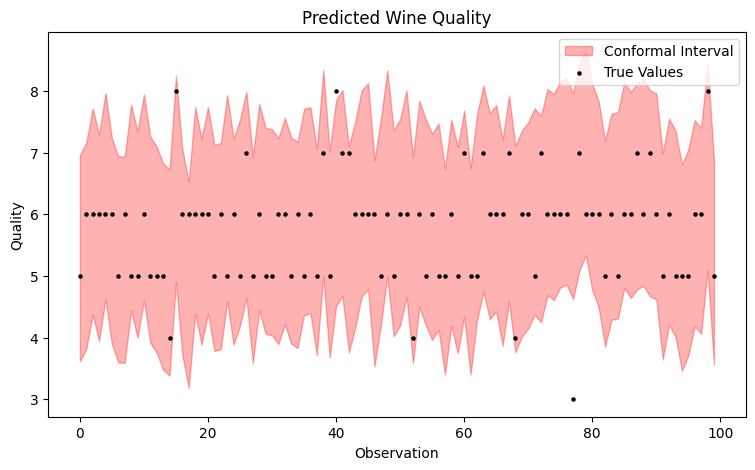

In [63]:
# Function for plotting
def plot_conformal_intervals(lower, upper, y_new, start=0, end=None):

    subset_range = slice(start, end)

    # Ensuring data is 1D
    lower = np.array(lower).flatten()
    upper = np.array(upper).flatten()
    y_new = np.array(y_new).flatten()
    
    fig, ax = plt.subplots(figsize=(9,5))
    
    plt.xlabel('Observation')
    plt.ylabel('Quality')
    plt.title('Predicted Wine Quality')
    plt.legend(loc='upper right')

    # Intervals
    plt.fill_between(np.arange(start, end if end is not None else len(lower)),
                     lower[subset_range], 
                     upper[subset_range], 
                     color='red', 
                     alpha=0.3, 
                     label='Conformal Interval')

    # True values
    plt.scatter(np.arange(start, end if end is not None else len(y_new)), 
                y_new[subset_range], 
                color='black', 
                s=5, 
                label='True Values')

    plt.legend()
    plt.show()

# Plot
plot_conformal_intervals(lower_bounds, upper_bounds, y_new, start=0, end=100)